In [60]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import cv2

In [84]:
#detrend function: detrend use polynomial fit
def detrend(x,y,degree):
    import statsmodels.formula.api as smf
    import numpy as np
    import pandas as pd
    

    df = pd.DataFrame(columns=['y', 'x'])
    df['x'] = x
    df['y'] = pd.Series(y)   #y

    idx = np.isfinite(x) & np.isfinite(y)
    weights = np.polyfit(x[idx], y[idx], degree)
    model = np.poly1d(weights)
    results = smf.ols(formula='y ~ model(x)', data=df).fit()

    p_value=results.f_pvalue
    r2=results.rsquared_adj

    detrend_ts=np.zeros(shape=(len(y),))
    detrend_ts[:] = np.nan
    detrend_ts[idx]=y[idx]-results.fittedvalues

    #plt.figure(figsize=(10,4))
    #plt.plot(x,y)
    #plt.plot(x[idx], results.fittedvalues, 'r')
    #plt.figure(figsize=(10,4))
    #plt.plot(x, detrend_ts)
    #plt.show()

    return p_value, r2, detrend_ts

In [62]:
def arrhydro(TS):
    N=6
    data = np.zeros(shape=(len(TS)))
    data[:] = np.nan   
    data[12:len(TS)]=TS[N:len(TS)-N]
    #hydro_TS = xr.DataArray(data,name='sst', coords={'time':TS.time}, dims=('time'))    
    #print(hydro_TS)
    return data

In [63]:
def calannual(TS):
    
    #annual
    dt1= TS.groupby('time.year').mean('time',keep_attrs=True)


    nsample = np.linspace(1,len(dt1), len(dt1))
    [p_value, r2, detrend_ts]= detrend(nsample,dt1,1)
    detrend_had=xr.DataArray(detrend_ts,                                  
                      name='sst',             
                      coords={'year':dt1.year},    
                      dims=('year')                        
                     )    

    return detrend_had

In [64]:
fm='./LME_all_mask.nc'  #-180~180  lon
dt_mask0=xr.open_dataset(fm)
dt_mask0.close()
#mask0=dt_mask0
#ilme0=3 #California Current 

fm='./STATE_all_mask.nc'  #-180~180  lon
dt_mask=xr.open_dataset(fm)
dt_mask.close()
#mask=dt_mask
#ilme=25 #California
#dt_mask.region_mask.where(dt_mask.region_mask==ilme)

In [65]:
#masking CA
dt_mask2=dt_mask*0
dt_mask2['region_mask']=25
mask = dt_mask2.where((dt_mask==25),0)
mask

<xarray.Dataset>
Dimensions:      (lat: 1800, lon: 3600, region: 52)
Coordinates:
  * lon          (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * lat          (lat) float64 -90.0 -89.9 -89.8 -89.7 ... 89.6 89.7 89.8 89.9
  * region       (region) int64 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52
Data variables:
    region_mask  (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    STATE_NAME   (region) object 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0

In [66]:
#masking CC
dt_mask2=dt_mask0*0
dt_mask2['region_mask']=3
mask0 = dt_mask2.where((dt_mask0==3),0)
mask0

<xarray.Dataset>
Dimensions:      (lat: 1800, lon: 3600, region: 67)
Coordinates:
  * lon          (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * lat          (lat) float64 -90.0 -89.9 -89.8 -89.7 ... 89.6 89.7 89.8 89.9
  * region       (region) int32 1 2 3 4 5 6 7 8 9 ... 59 60 61 62 63 64 65 66 67
Data variables:
    region_mask  (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    LME_names    (region) object 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0

In [67]:
#masking GOA
dt_mask2=dt_mask0*0
dt_mask2['region_mask']=2
mask2 = dt_mask2.where((dt_mask2.lat<60)&(dt_mask2.lat>30)&(dt_mask2.lon>-160)&(dt_mask2.lon<-130),0)
mask2

<xarray.Dataset>
Dimensions:      (lat: 1800, lon: 3600, region: 67)
Coordinates:
  * lon          (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * lat          (lat) float64 -90.0 -89.9 -89.8 -89.7 ... 89.6 89.7 89.8 89.9
  * region       (region) int32 1 2 3 4 5 6 7 8 9 ... 59 60 61 62 63 64 65 66 67
Data variables:
    region_mask  (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    LME_names    (region, lat, lon) object 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0

In [68]:
#masking nino3.4
dt_mask3=dt_mask0*2
ilme3=9
dt_mask3['region_mask']=ilme3
mask3 = dt_mask3.where((dt_mask3.lat<5)&(dt_mask3.lat>-5)&(dt_mask3.lon>-170)&(dt_mask3.lon<-120),0)
mask3

<xarray.Dataset>
Dimensions:      (lat: 1800, lon: 3600, region: 67)
Coordinates:
  * lon          (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * lat          (lat) float64 -90.0 -89.9 -89.8 -89.7 ... 89.6 89.7 89.8 89.9
  * region       (region) int32 1 2 3 4 5 6 7 8 9 ... 59 60 61 62 63 64 65 66 67
Data variables:
    region_mask  (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    LME_names    (region, lat, lon) object 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0

In [69]:
#season='winter'
fn='./HadISST_sst.nc'
dt0=xr.open_dataset(fn)
dt0.close()
dt0.time

<xarray.DataArray 'time' (time: 1804)>
array(['1870-01-16T11:59:59.505615234', '1870-02-14T23:59:59.340820312',
       '1870-03-16T11:59:59.340820312', ..., '2020-02-16T12:00:00.000000000',
       '2020-03-16T12:00:00.000000000', '2020-04-16T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1870-01-16T11:59:59.505615234 ... 2020-04-16T12:00:00
Attributes:
    long_name:      Time
    standard_name:  time

In [70]:
initial_date = '1980-01-01'
final_date   =  '2019-12-31' #'2019-10-31'
p2_start_date = '1981-01-01'
p2_end_date ='2010-12-31'
dt_had=dt0.sel(time=slice(initial_date , final_date)).where(dt0.sst>-1)
nt=len(dt_had.time)
nlat=len(dt_had.latitude)
nlon=len(dt_had.longitude)
dt_had.sst.values.shape

(480, 180, 360)

In [71]:
a=dt_had.sst.values.reshape((nt,-1))
b=np.apply_along_axis(arrhydro, 0, a)
hydro_had = xr.DataArray(b.reshape((nt,nlat,nlon)),                                  
                  name='sst',             
                  coords={'time':dt_had.time,'lat':dt_had.latitude,'lon':dt_had.longitude},    
                  dims=('time','latitude','longitude')                        
                          ) 

ann=hydro_had.groupby('time.year').mean('time',keep_attrs=True)

#anom_had=np.apply_along_axis(detrend, 0, ann)
ref_clim=ann.sel(year=slice(p2_start_date , p2_end_date)).mean('year')
anom_had=ann-ref_clim


anom_had


/Users/huishi/miniconda3/envs/tutorialenv/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'sst' (year: 40, latitude: 180, longitude: 360)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
    lat      (latitude) float32 89.5 88.5 87.5 86.5 ... -86.5 -87.5 -88.5 -89.5
    lon      (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * year     (year) int64 1980 1981 1982 1983 1984 ... 2015 2016 2017 2018 2019
Dimensions without coordinates: latitude, longitude

In [72]:
anom_had=xr.DataArray(anom_had,                                  
                  name='sst',             
                  coords={'year':ann.year,'lat':ann.lat,'lon':ann.lon},    
                  dims=('year','latitude','longitude')) 

anom_had

<xarray.DataArray 'sst' (year: 40, latitude: 180, longitude: 360)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * year     (year) int64 1980 1981 1982 1983 1984 ... 2015 2016 2017 2018 2019
    lat      (latitude) float32 89.5 88.5 87.5 86.5 ... -86.5 -87.5 -88.5 -89.5
    lon      (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Dimensions without coordinates: latitude, longitude

In [73]:
fn='./tos_Omon_ACCESS-CM2_histssp585_185001-210012.nc'
dt1=xr.open_dataset(fn)
dt1.close()
dt1

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 360, lon: 720, time: 3012)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2100-12-16T12:00:00
  * lon        (lon) float64 0.0 0.5 1.0 1.5 2.0 ... 358.0 358.5 359.0 359.5
  * lat        (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    tos        (time, lat, lon) float32 ...
Attributes:
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    history:                Fri Mar  6 23:02:56 2020: ncrcat -O /Volumes/DATA...
    source:                 ACCESS-CM2 (2019): \naerosol: UKCA-GLOMAP-mode\na...
    institution:            CSIRO (Commonwealth Scientific and Industrial Res...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2019-11-08T18:45:44Z
    data_specs_version:     01.00.30
    experiment:             all-forcing simulation of the recent past
    experiment_id:          historical
    external_variables:     areacello
    forcing_index:          1
    frequency:              mon
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.CSIRO-ARCCSS...
    grid:                   native atmosphere N96 grid (144x192 latxlon)
    grid_label:             gn
    initialization_index:   1
    institution_id:         CSIRO-ARCCSS
    mip_era:                CMIP6
    nominal_resolution:     250 km
    notes:                  Exp: CM2-historical; Local ID: bj594; Variable: t...
    parent_activity_id:     CMIP
    parent_experiment_id:   piControl
    parent_mip_era:         CMIP6
    parent_source_id:       ACCESS-CM2
    parent_time_units:      days since 0950-01-01
    parent_variant_label:   r1i1p1f1
    physics_index:          1
    product:                model-output
    realization_index:      1
    realm:                  ocean
    run_variant:            forcing: GHG, Oz, SA, Sl, Vl, BC, OC, (GHG = CO2,...
    source_id:              ACCESS-CM2
    source_type:            AOGCM
    sub_experiment:         none
    sub_experiment_id:      none
    table_id:               Omon
    table_info:             Creation Date:(30 April 2019) MD5:e14f55f257cceaf...
    title:                  ACCESS-CM2 output prepared for CMIP6
    variable_id:            tos
    variant_label:          r1i1p1f1
    version:                v20191108
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/0bcaaa74-aedb-4d45-a5e5-cb3ab467f2b5
    license:                CMIP6 model data produced by CSIRO is licensed un...
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...
    NCO:                    netCDF Operators version 4.9.1 (Homepage = http:/...

In [74]:
fn='./pdsisc.monthly.maps.1850-2018.fawc=1.r2.5x2.5.ipe=2.nc'
dt0=xr.open_dataset(fn)
dt0.close()
dt0['time']=dt1.time.sel(time=slice('1850-01-01','2018-12-31'))
dt0

<xarray.Dataset>
Dimensions:     (lat: 55, lon: 144, time: 2028)
Coordinates:
  * lat         (lat) float32 -58.75 -56.25 -53.75 -51.25 ... 71.25 73.75 76.25
  * lon         (lon) float32 -178.75 -176.25 -173.75 ... 173.75 176.25 178.75
  * time        (time) datetime64[ns] 1850-01-16T12:00:00 ... 2018-12-16T12:00:00
Data variables:
    sc_PDSI_pm  (time, lat, lon) float32 ...
Attributes:
    creation_time:  Fri Mar 29 13:58:09 EDT 2019
    Conventions:    NCAR
    source_file:    tmp2/DaiP_4.02/pdsisc.monthly.maps.1850-2018.fawc=1.r2.5x...
    description:    \nMonthly Self-calibrated Palmer Drought Severity Index (...

In [75]:
dt_pdsi=dt0.sel(time=slice(initial_date , final_date))
nt=len(dt_pdsi.time)
nlat=len(dt_pdsi.lat)
nlon=len(dt_pdsi.lon)
dt_pdsi.sc_PDSI_pm.values.shape

(468, 55, 144)

In [76]:
a=dt_pdsi.sc_PDSI_pm.values.reshape((nt,-1))
b=np.apply_along_axis(arrhydro, 0, a)
hydro_had = xr.DataArray(b.reshape((nt,nlat,nlon)),                                  
                  name='sst',             
                  coords={'time':dt_pdsi.time,'lat':dt_pdsi.lat,'lon':dt_pdsi.lon},    
                  dims=('time','lat','lon')                        
                          ) 
ann=hydro_had.groupby('time.year').mean('time',keep_attrs=True)
#anom_pdsi=np.apply_along_axis(detrend, 0, ann)

ref_clim=ann.sel(year=slice(p2_start_date , p2_end_date)).mean('year')
anom_pdsi=ann-ref_clim


anom_pdsi=xr.DataArray(anom_pdsi,                                  
                  name='pdsi',             
                  coords={'year':ann.year,'lat':ann.lat,'lon':ann.lon},    
                  dims=('year','lat','lon')) 

anom_pdsi


/Users/huishi/miniconda3/envs/tutorialenv/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'pdsi' (year: 39, lat: 55, lon: 144)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 1.34701391,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 1.90008417,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       ...,

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-1.10285412,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.37572923,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 2.60428876,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * year     (year) int64 1980 1981 1982 1983 1984 ... 2014 2015 2016 2017 2018
  * lat      (lat) float32 -58.75 -56.25 -53.75 -51.25 ... 71.25 73.75 76.25

In [77]:
fn='./hgt.mon.mean_1979.nc'
dt0=xr.open_dataset(fn)
dt0.close()
dt0#.level[5]


/Users/huishi/miniconda3/envs/tutorialenv/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'hgt' has multiple fill values {-32767, 32766}, decoding all values to NaN.
  use_cftime=use_cftime,


<xarray.Dataset>
Dimensions:    (lat: 73, level: 17, lon: 144, nbnds: 2, time: 494)
Coordinates:
  * level      (level) float32 1000.0 925.0 850.0 700.0 ... 50.0 30.0 20.0 10.0
  * lat        (lat) float32 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
  * lon        (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-02-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) datetime64[ns] ...
    hgt        (time, level, lat, lon) float32 ...
Attributes:
    Conventions:    CF-1.0
    title:          Monthly NCEP/DOE Reanalysis 2
    history:        created 2002/03 by Hoop (netCDF2.3)
    comments:       Data is from \nNCEP/DOE AMIP-II Reanalysis (Reanalysis-2)...
    platform:       Model
    source:         NCEP/DOE AMIP-II Reanalysis (Reanalysis-2) Model
    institution:    National Centers for Environmental Prediction
    dataset_title:  NCEP-DOE AMIP-II Reanalysis
    References:     https://www.esrl.noaa.gov/psd/data/gridded/data.ncep.rean...
    source_url:     http://www.cpc.ncep.noaa.gov/products/wesley/reanalysis2/

In [78]:
dt_hgt=dt0.sel(time=slice(initial_date , final_date)).sel(level=500)
nt=len(dt_hgt.time)
nlat=len(dt_hgt.lat)
nlon=len(dt_hgt.lon)
dt_hgt.hgt.values.shape

(480, 73, 144)

In [79]:
a=dt_hgt.hgt.values.reshape((nt,-1))
b=np.apply_along_axis(arrhydro, 0, a)
hydro_had = xr.DataArray(b.reshape((nt,nlat,nlon)),                                  
                  name='sst',             
                  coords={'time':dt_hgt.time,'lat':dt_hgt.lat,'lon':dt_hgt.lon},    
                  dims=('time','lat','lon')                        
                          ) 

ann=hydro_had.groupby('time.year').mean('time',keep_attrs=True)
#anom_hgt=np.apply_along_axis(detrend, 0, ann)
ref_clim=ann.sel(year=slice(p2_start_date , p2_end_date)).mean('year')
anom_hgt=ann-ref_clim


anom_hgt=xr.DataArray(anom_hgt,                                  
                  name='hgt',             
                  coords={'year':ann.year,'lat':ann.lat,'lon':ann.lon},    
                  dims=('year','lat','lon')) 

anom_hgt



/Users/huishi/miniconda3/envs/tutorialenv/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'hgt' (year: 40, lat: 73, lon: 144)>
array([[[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        ...,
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[  4.51436782,   4.51436782,   4.51436782, ...,   4.51436782,
           4.51436782,   4.51436782],
        [ -4.30747126,  -4.85057471,  -4.86781609, ...,  -3.12643678,
          -3.57183908,  -3.98563218],
        [-16.29597701, -17.19827586, -17.90517241, ..., -13.20689655,
         -14.34770115, -15.28448276],
        ...,
        [ 15.79597701,  15.88505747,  15.58045977, ...,  16.35632184,
          16.43965517,  16.08333333],
        [ 14.66666667,  14.83333333,  14.37356322, ...,  15.12931034,
          14.83333333,  14.79885057],
        [ 17.40517241,  17.40517241,  17.40517241, ...,  17.40517241,
          17.40517241,  17.40517241]],

       [[ 23.18103448,  23.18103448,  23.18103448, ...,  23.18103448,
          23.18103448,  23.18103448],
        [ 22.6091954 ,  22.31609195,  22.21551724, ...,  23.37356322,
          23.09482759,  22.84770115],
        [ 18.28735632,  17.7183908 ,  17.26149425, ...,  19.87643678,
          19.23563218,  18.71551724],
        ...,
        [-21.62068966, -21.86494253, -22.25287356, ..., -20.97701149,
         -21.31034483, -21.5       ],
        [-27.08333333, -27.25      , -27.12643678, ..., -26.87068966,
         -27.        , -26.86781609],
        [-29.67816092, -29.67816092, -29.67816092, ..., -29.67816092,
         -29.67816092, -29.67816092]],

       ...,

       [[-10.90229885, -10.90229885, -10.90229885, ..., -10.90229885,
         -10.90229885, -10.90229885],
        [ -4.3908046 ,  -4.60057471,  -4.53448276, ...,  -4.62643678,
          -4.48850575,  -4.56896552],
        [  4.20402299,   4.30172414,   4.34482759, ...,   4.04310345,
           4.15229885,   4.04885057],
        ...,
        [ 19.04597701,  19.2183908 ,  19.33045977, ...,  18.68965517,
          18.85632184,  19.        ],
        [ 25.        ,  24.83333333,  25.04022989, ...,  24.62931034,
          24.66666667,  24.71551724],
        [ 25.15517241,  25.15517241,  25.15517241, ...,  25.15517241,
          25.15517241,  25.15517241]],

       [[ 46.68103448,  46.68103448,  46.68103448, ...,  46.68103448,
          46.68103448,  46.68103448],
        [ 45.94252874,  46.14942529,  46.46551724, ...,  44.79022989,
          45.17816092,  45.34770115],
        [ 46.45402299,  47.13505747,  47.84482759, ...,  44.20977011,
          44.98563218,  45.54885057],
        ...,
        [ 12.71264368,  13.05172414,  13.1637931 , ...,  12.27298851,
          12.43965517,  12.5       ],
        [ 13.83333333,  14.08333333,  14.04022989, ...,  13.29597701,
          13.5       ,  13.63218391],
        [ 13.15517241,  13.15517241,  13.15517241, ...,  13.15517241,
          13.15517241,  13.15517241]],

       [[ 11.76436782,  11.76436782,  11.76436782, ...,  11.76436782,
          11.76436782,  11.76436782],
        [ 13.19252874,  13.06609195,  12.63218391, ...,  13.70689655,
          13.76149425,  13.51436782],
        [ 16.95402299,  16.4683908 ,  16.01149425, ...,  17.95977011,
          17.73563218,  17.29885057],
        ...,
        [  7.04597701,   7.13505747,   7.49712644, ...,   6.85632184,
           6.93965517,   7.08333333],
        [ 11.58333333,  11.66666667,  11.62356322, ...,  11.62931034,
          11.91666667,  11.88218391],
        [ 12.48850575,  12.48850575,  12.48850575, ...,  12.4885

[-40. -32. -24. -16.  -8.   0.   8.  16.  24.  32.  40.  48.  56.  64.
  72.  80.]
[-40. -32. -24. -16.  -8.   0.   8.  16.  24.  32.  40.  48.  56.  64.]


/Users/huishi/miniconda3/envs/tutorialenv/lib/python3.7/site-packages/ipykernel_launcher.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


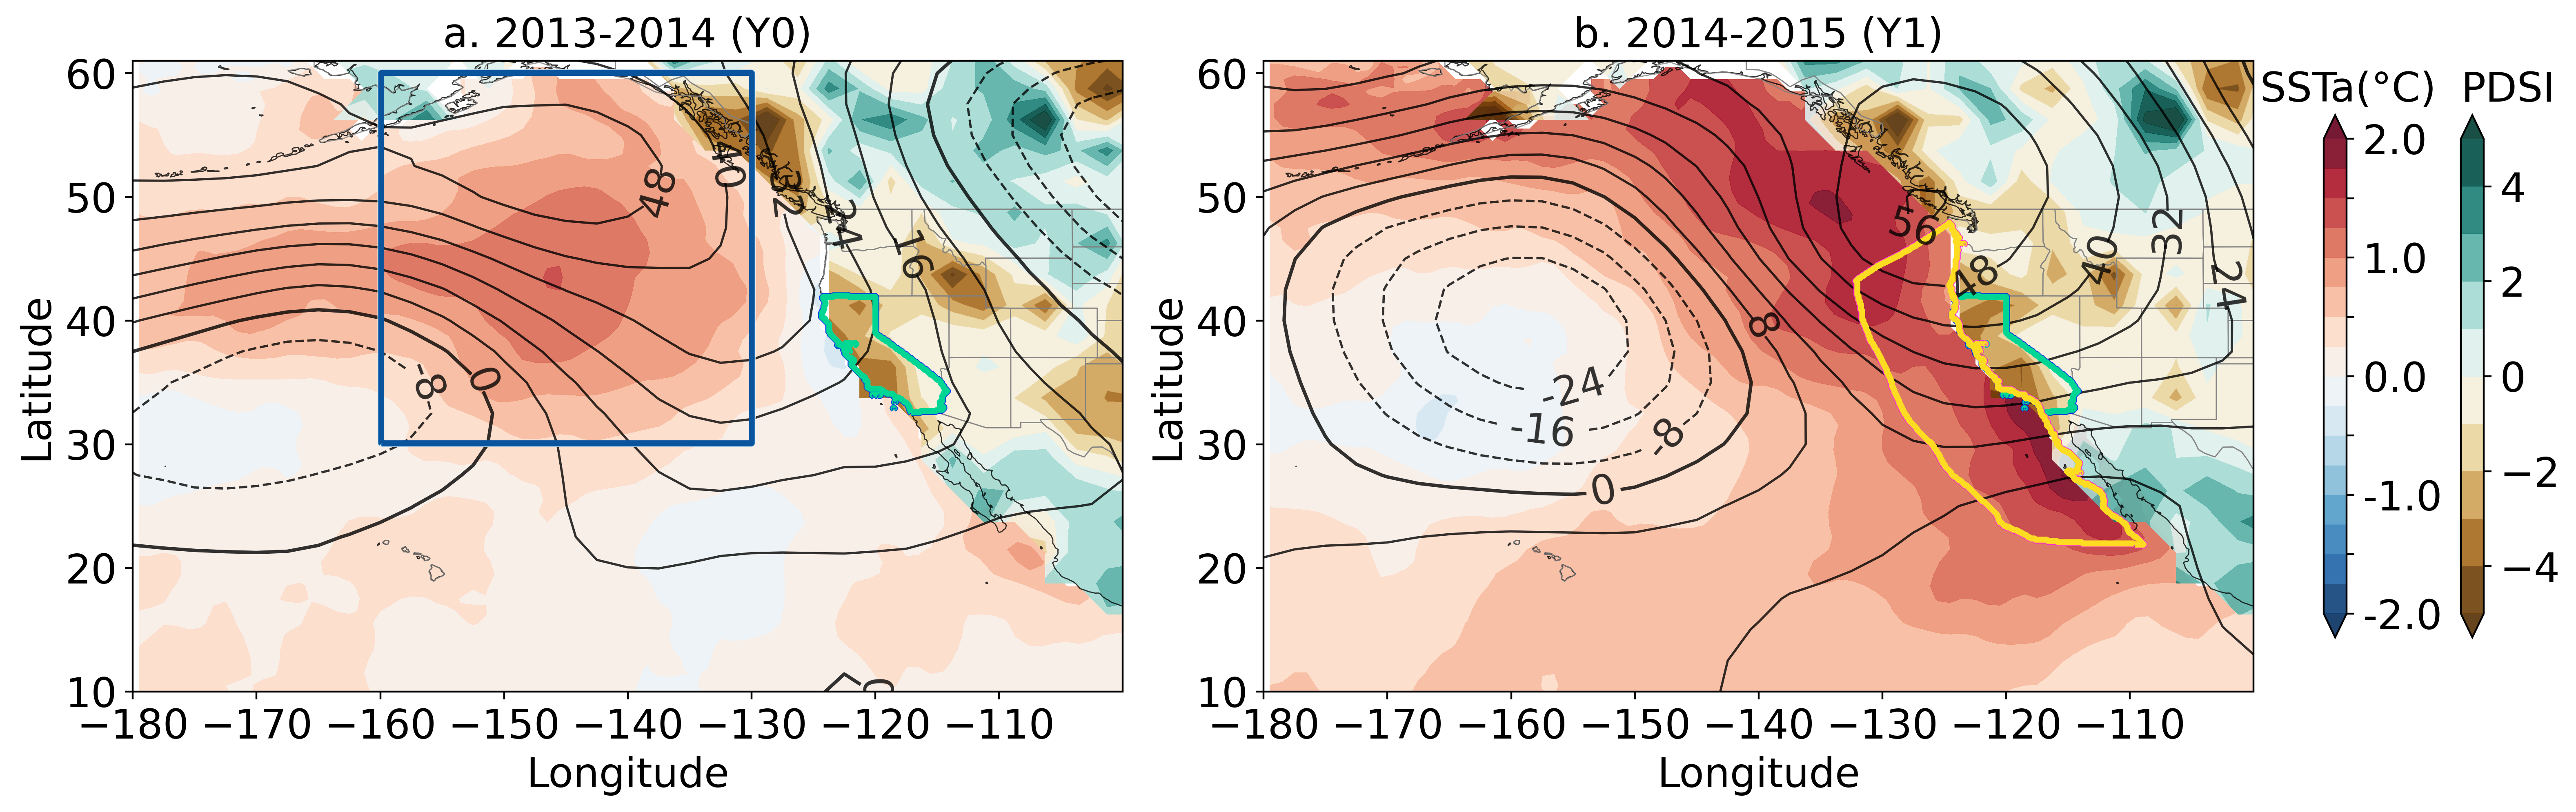

In [91]:
#fig= plt.figure(figsize=(15,10), dpi=200)

fig, axs = plt.subplots(1, 2,figsize=(14,8), dpi=400)

lev=np.arange(-2.,2.1,0.25)  #0.25
cm='RdBu_r'
lev1=np.arange(-5,5.1,1) #1
cm1='BrBG'
alpha = ['a', 'b', 'c', 'd','e','f']

fz=18
#for i in range(2014,2017):
i=2014
y=anom_had.sel(year=i)
z=anom_pdsi.sel(year=i)
k=anom_hgt.sel(year=i)


ax2=plt.subplot(1,2,(i-2013),projection=ccrs.PlateCarree())
ax2.coastlines(resolution='50m',linewidth=0.5,color='black',alpha=0.8,zorder=1)
ax2.set_extent([-180,-100,10,61],crs=ccrs.PlateCarree())
ax2.set_xticks(range(-180,-100,10), crs=ccrs.PlateCarree())
ax2.set_yticks(range(10,61,10), crs=ccrs.PlateCarree())

#from matplotlib.patches import Rectangle
#someX, someY = -160, 30
#currentAxis = plt.gca()
#currentAxis.add_patch(Rectangle((someX , someY ), 30, 30,alpha=.8, fill=None,))#,facecolor="grey"

plt.grid(True,alpha=0.5,zorder=0)
plt.ylabel('Latitude' ,fontsize=fz)
plt.xlabel('Longitude', fontsize=fz)
plt.rc('xtick',labelsize=fz) 
plt.rc('ytick',labelsize=fz) 
plt.title(alpha[i-2014]+'. '+ str(i-1)+'-'+str(i)+' (Y0)', fontsize=fz)

im = plt.contourf(y.lon,y.lat,y, alpha=0.9, cmap=cm, levels=lev,extend="both")
#cbar = plt.colorbar(fraction=0.04, pad=0.1 ,orientation="horizontal")

im1 = plt.contourf(z.lon,z.lat,z, alpha=0.9, cmap=cm1, levels=lev1,extend="both")
#cbar2 = plt.colorbar(fraction=0.04, pad=0.04)

CS = plt.contour(k.lon,k.lat,k, levels=14,alpha=.8, linewidths=1, colors='k')
ax.clabel(CS, inline=1, fontsize=fz,fmt='%1.0f')
print(CS.levels)
CS.collections[5].set_linewidth(1.5) 

country = cfeature.BORDERS
states = cfeature.STATES #NaturalEarthFeature(
ax2.add_feature(states, edgecolor='gray',linewidth=0.5,alpha=0.8)
ax2.add_feature(country, edgecolor='gray',linewidth=0.5,alpha=0.8)

cs= ax2.contour(mask.lon,mask.lat,mask.region_mask, linewidths=2.5, alpha=0.9, cmap='winter')
#cs= ax2.contour(mask0.lon,mask0.lat,mask0.region_mask, alpha=0.7, cmap='copper')
cs= ax2.contour(mask2.lon,mask2.lat,mask2.region_mask, linewidths=2.5, alpha=0.9, cmap='Blues')#'RdBu_r')





i=2015
y=anom_had.sel(year=i)
z=anom_pdsi.sel(year=i)
k=anom_hgt.sel(year=i)


ax2=plt.subplot(1,2,(i-2013),projection=ccrs.PlateCarree())
ax2.coastlines(resolution='50m',linewidth=0.5,color='black',alpha=0.8,zorder=1)
ax2.set_extent([-180,-100,10,61],crs=ccrs.PlateCarree())
ax2.set_xticks(range(-180,-100,10), crs=ccrs.PlateCarree())
ax2.set_yticks(range(10,61,10), crs=ccrs.PlateCarree())


plt.grid(True,alpha=0.5,zorder=0)
plt.ylabel('Latitude', fontsize=fz)
plt.xlabel('Longitude', fontsize=fz)
plt.rc('xtick',labelsize=fz) 
plt.rc('ytick',labelsize=fz)  
plt.title(alpha[i-2014]+'. '+ str(i-1)+'-'+str(i)+' (Y1)', fontsize=fz)

im = plt.contourf(y.lon,y.lat,y, alpha=0.9, cmap=cm, levels=lev,extend="both")
#cbar = plt.colorbar(fraction=0.04, pad=0.1 ,orientation="horizontal")

im1 = plt.contourf(z.lon,z.lat,z, alpha=0.9, cmap=cm1, levels=lev1,extend="both")
#cbar2 = plt.colorbar(fraction=0.04, pad=0.04)

CS = plt.contour(k.lon,k.lat,k, levels=14, linewidths=1,alpha=.8, colors='k')
ax.clabel(CS, inline=1, fontsize=fz,fmt='%1.0f')
print(CS.levels)
CS.collections[5].set_linewidth(1.5)

country = cfeature.BORDERS
states = cfeature.STATES #NaturalEarthFeature(
ax2.add_feature(states, edgecolor='gray',linewidth=0.5,alpha=0.8)
ax2.add_feature(country, edgecolor='gray',linewidth=0.5,alpha=0.8)


cs= ax2.contour(mask.lon,mask.lat,mask.region_mask, linewidths=2.5, alpha=0.9, cmap='winter')
cs= ax2.contour(mask0.lon,mask0.lat,mask0.region_mask,  linewidths=2.5, alpha=0.9, cmap='spring')  #'Wistia')
#cs= ax2.contour(mask2.lon,mask2.lat,mask2.region_mask, alpha=0.7, cmap='Blues')#'RdBu_r')




cax = plt.axes([1.02, 0.3, 0.01, 0.4])
cbar = plt.colorbar(im,cax=cax, fraction=0.015, orientation ='vertical')
cbar.ax.set_title('  SSTa(°C)', rotation=0,loc='center', fontsize=fz)
cbar.ax.set_yticklabels(['-2.0', '','-1.0','','0.0', '','1.0','','2.0'])


cax = plt.axes([1.08, 0.3, 0.01, 0.4])
cbar1=plt.colorbar(im1,cax=cax, fraction=0.015, orientation ='vertical') #, pad=-0.7
cbar1.ax.set_title('PDSI', rotation=0,loc='left', fontsize=fz)
#cbar1.ax.set_yticklabels(['-4', '','-2','','0.0', '','2','','4'])



plt.tight_layout()
plt.show()

In [ ]:
#plot time series with bars

In [81]:
file = './obs_ts.xlsx'# annual.xlsx' # obs indices.xlsx'
df = pd.read_excel(file)
df = df.rename(columns={'cc_sst':'CC_SST','nino':'NINO','ca_pdsi':'CA_PDSI', 'goa_sst':'GOA_SST' , 'nph':'NPH', 'large_cum_rrr_2y':'Ridge'})
df = df[(df.year>=1900)&(df.year<=2019)]
df

,Unnamed: 0,year,NINO,GOA_SST,goa_small_sst,goa_delta_t,CC_SST,ca_pr,CA_PDSI,ca_sm,...,mhw_only_rrr,coo_rrr_east,coo_rrr_east_2y,coo_rrr_20c_ncep2,coo_cum_rrr_2y,coo_cum_rrr_3y,ineff_rrr_20c_ncep2,large_rrr_20c_ncep2,Ridge,large_cum_rrr_3y
0,0.0,1900.0,NaN,NaN,10.362180,NaN,NaN,NaN,0.721667,NaN,...,5469.667114,5598.529175,NaN,5589.439209,NaN,NaN,5495.312703,5534.651693,NaN,NaN
1,1.0,1901.0,27.261850,12.809047,10.208267,NaN,16.829166,NaN,1.702500,NaN,...,5503.680786,5607.023438,11205.552612,5604.052043,11193.491252,NaN,5532.893392,5555.903117,11090.554810,NaN
2,2.0,1902.0,26.767965,12.593447,9.884762,-0.215600,16.634994,1.561781,0.994167,NaN,...,5473.336670,5588.879801,11195.903239,5580.924764,11184.976807,16774.416016,5506.384033,5535.371582,11091.274699,16625.926392
3,3.0,1903.0,28.030883,12.457354,9.880752,-0.136094,16.627659,1.597637,1.012500,NaN,...,5484.465535,5589.709229,11178.589030,5585.677979,11166.602743,16770.654785,5510.469360,5536.657511,11072.029093,16627.932210
4,4.0,1904.0,26.382762,12.475911,9.798757,0.018558,16.402490,1.776581,0.593333,NaN,...,5453.463460,5580.745809,11170.455037,5571.707520,11157.385498,16738.310262,5493.680501,5523.395386,11060.052897,16595.424479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,115.0,2015.0,27.666291,13.899565,11.422862,0.125449,18.626306,1.314730,-5.377500,351.264837,...,5524.014608,5653.093709,11296.947510,5647.304728,11290.670247,16925.329997,5540.325358,5583.290202,11176.569661,16764.975627
116,116.0,2016.0,28.720407,13.606849,11.123237,-0.292716,18.508735,1.729328,-3.305833,366.556740,...,5500.390584,5622.563110,11275.656820,5616.114095,11263.418823,16906.784342,5526.118368,5561.388916,11144.679118,16737.958577
117,117.0,2017.0,26.642849,13.274127,10.632543,-0.332723,17.574502,2.344241,0.380000,408.123276,...,5506.836222,5597.694417,11220.257528,5592.582194,11208.696289,16856.001017,5545.069132,5559.553711,11120.942627,16704.232829
118,118.0,2018.0,26.491223,13.274407,10.522652,0.000280,17.597217,1.160726,-2.162500,373.505885,...,5536.602824,5640.263102,11237.957520,5637.507731,11230.089925,16846.204020,5571.355672,5591.758504,11151.312215,16712.701131


In [85]:
per=0.9  #0.9
per2=0.1  #0.1

cc_mhw=df['CC_SST']/df['CC_SST']*0
goa_mhw=df['CC_SST']/df['CC_SST']*0
ca_dgt=df['CC_SST']/df['CC_SST']*0

for i in range(1900,1991):   #1914-2004
    print(i)
    df_ref=df[(df.year>=i)&(df.year<=i+29)]
    tmp1_0=df_ref['CC_SST'].values
    tmp2_0=df_ref['GOA_SST'].values
    tmp3_0=df_ref['CA_PDSI'].values
    #print(tmp1_0)

    #detrend
    nsample = np.linspace(1,len(tmp1_0), len(tmp1_0))
    [p_value, r2, tmp1]= detrend(nsample,tmp1_0,1)
    nsample = np.linspace(1,len(tmp2_0), len(tmp2_0))
    [p_value, r2, tmp2]= detrend(nsample,tmp2_0,1)
    nsample = np.linspace(1,len(tmp3_0), len(tmp3_0))
    [p_value, r2, tmp3]= detrend(nsample,tmp3_0,1)
    #print(tmp1)

    if tmp1[14]>= np.nanquantile(tmp1,per):
        cc_mhw[i-1900+14]=1
    if tmp2[14]>= np.nanquantile(tmp2,per):
        goa_mhw[i-1900+14]=1
    if tmp3[14]<= np.nanquantile(tmp3,per2):
        ca_dgt[i-1900+14]=1
cc_mhw,goa_mhw,ca_dgt

1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990


(0      NaN
 1      0.0
 2      0.0
 3      0.0
 4      0.0
       ... 
 115    0.0
 116    0.0
 117    0.0
 118    0.0
 119    0.0
 Name: CC_SST, Length: 120, dtype: float64,
 0      NaN
 1      0.0
 2      0.0
 3      0.0
 4      0.0
       ... 
 115    0.0
 116    0.0
 117    0.0
 118    0.0
 119    0.0
 Name: CC_SST, Length: 120, dtype: float64,
 0      NaN
 1      0.0
 2      0.0
 3      0.0
 4      0.0
       ... 
 115    0.0
 116    0.0
 117    0.0
 118    0.0
 119    0.0
 Name: CC_SST, Length: 120, dtype: float64)

In [86]:
i=1900
df_ref=df[(df.year>=i)&(df.year<=i+29)]
tmp1_0=df_ref['CC_SST'].values
tmp2_0=df_ref['GOA_SST'].values
tmp3_0=df_ref['CA_PDSI'].values
#print(tmp1_0)

#detrend
nsample = np.linspace(1,len(tmp1_0), len(tmp1_0))
[p_value, r2, tmp1]= detrend(nsample,tmp1_0,1)
nsample = np.linspace(1,len(tmp2_0), len(tmp2_0))
[p_value, r2, tmp2]= detrend(nsample,tmp2_0,1)
nsample = np.linspace(1,len(tmp3_0), len(tmp3_0))
[p_value, r2, tmp3]= detrend(nsample,tmp3_0,1)
#print(tmp1)
for i in range(1900,1915):
    if tmp1[i-1900]>= np.nanquantile(tmp1,per):
        cc_mhw[i-1900]=1
    if tmp2[i-1900]>= np.nanquantile(tmp2,per):
        goa_mhw[i-1900]=1
    if tmp3[i-1900]<= np.nanquantile(tmp3,per2):
        ca_dgt[i-1900]=1
        
        
i=1990
df_ref=df[(df.year>=i)&(df.year<=i+29)]
tmp1_0=df_ref['CC_SST'].values
tmp2_0=df_ref['GOA_SST'].values
tmp3_0=df_ref['CA_PDSI'].values
#print(tmp1_0)

#detrend
nsample = np.linspace(1,len(tmp1_0), len(tmp1_0))
[p_value, r2, tmp1]= detrend(nsample,tmp1_0,1)
nsample = np.linspace(1,len(tmp2_0), len(tmp2_0))
[p_value, r2, tmp2]= detrend(nsample,tmp2_0,1)
nsample = np.linspace(1,len(tmp3_0), len(tmp3_0))
[p_value, r2, tmp3]= detrend(nsample,tmp3_0,1)
#print(tmp1)
for i in range(2004,2020):
    if tmp1[i-1990]>= np.nanquantile(tmp1,per):
        cc_mhw[i-1900]=1
    if tmp2[i-1990]>= np.nanquantile(tmp2,per):
        goa_mhw[i-1900]=1
    if tmp3[i-1990]<= np.nanquantile(tmp3,per2):
        ca_dgt[i-1900]=1
cc_mhw,goa_mhw,ca_dgt

(0      NaN
 1      0.0
 2      0.0
 3      0.0
 4      0.0
       ... 
 115    1.0
 116    1.0
 117    0.0
 118    0.0
 119    0.0
 Name: CC_SST, Length: 120, dtype: float64,
 0      NaN
 1      1.0
 2      0.0
 3      0.0
 4      0.0
       ... 
 115    1.0
 116    0.0
 117    0.0
 118    0.0
 119    0.0
 Name: CC_SST, Length: 120, dtype: float64,
 0      NaN
 1      0.0
 2      0.0
 3      0.0
 4      0.0
       ... 
 115    1.0
 116    0.0
 117    0.0
 118    0.0
 119    0.0
 Name: CC_SST, Length: 120, dtype: float64)

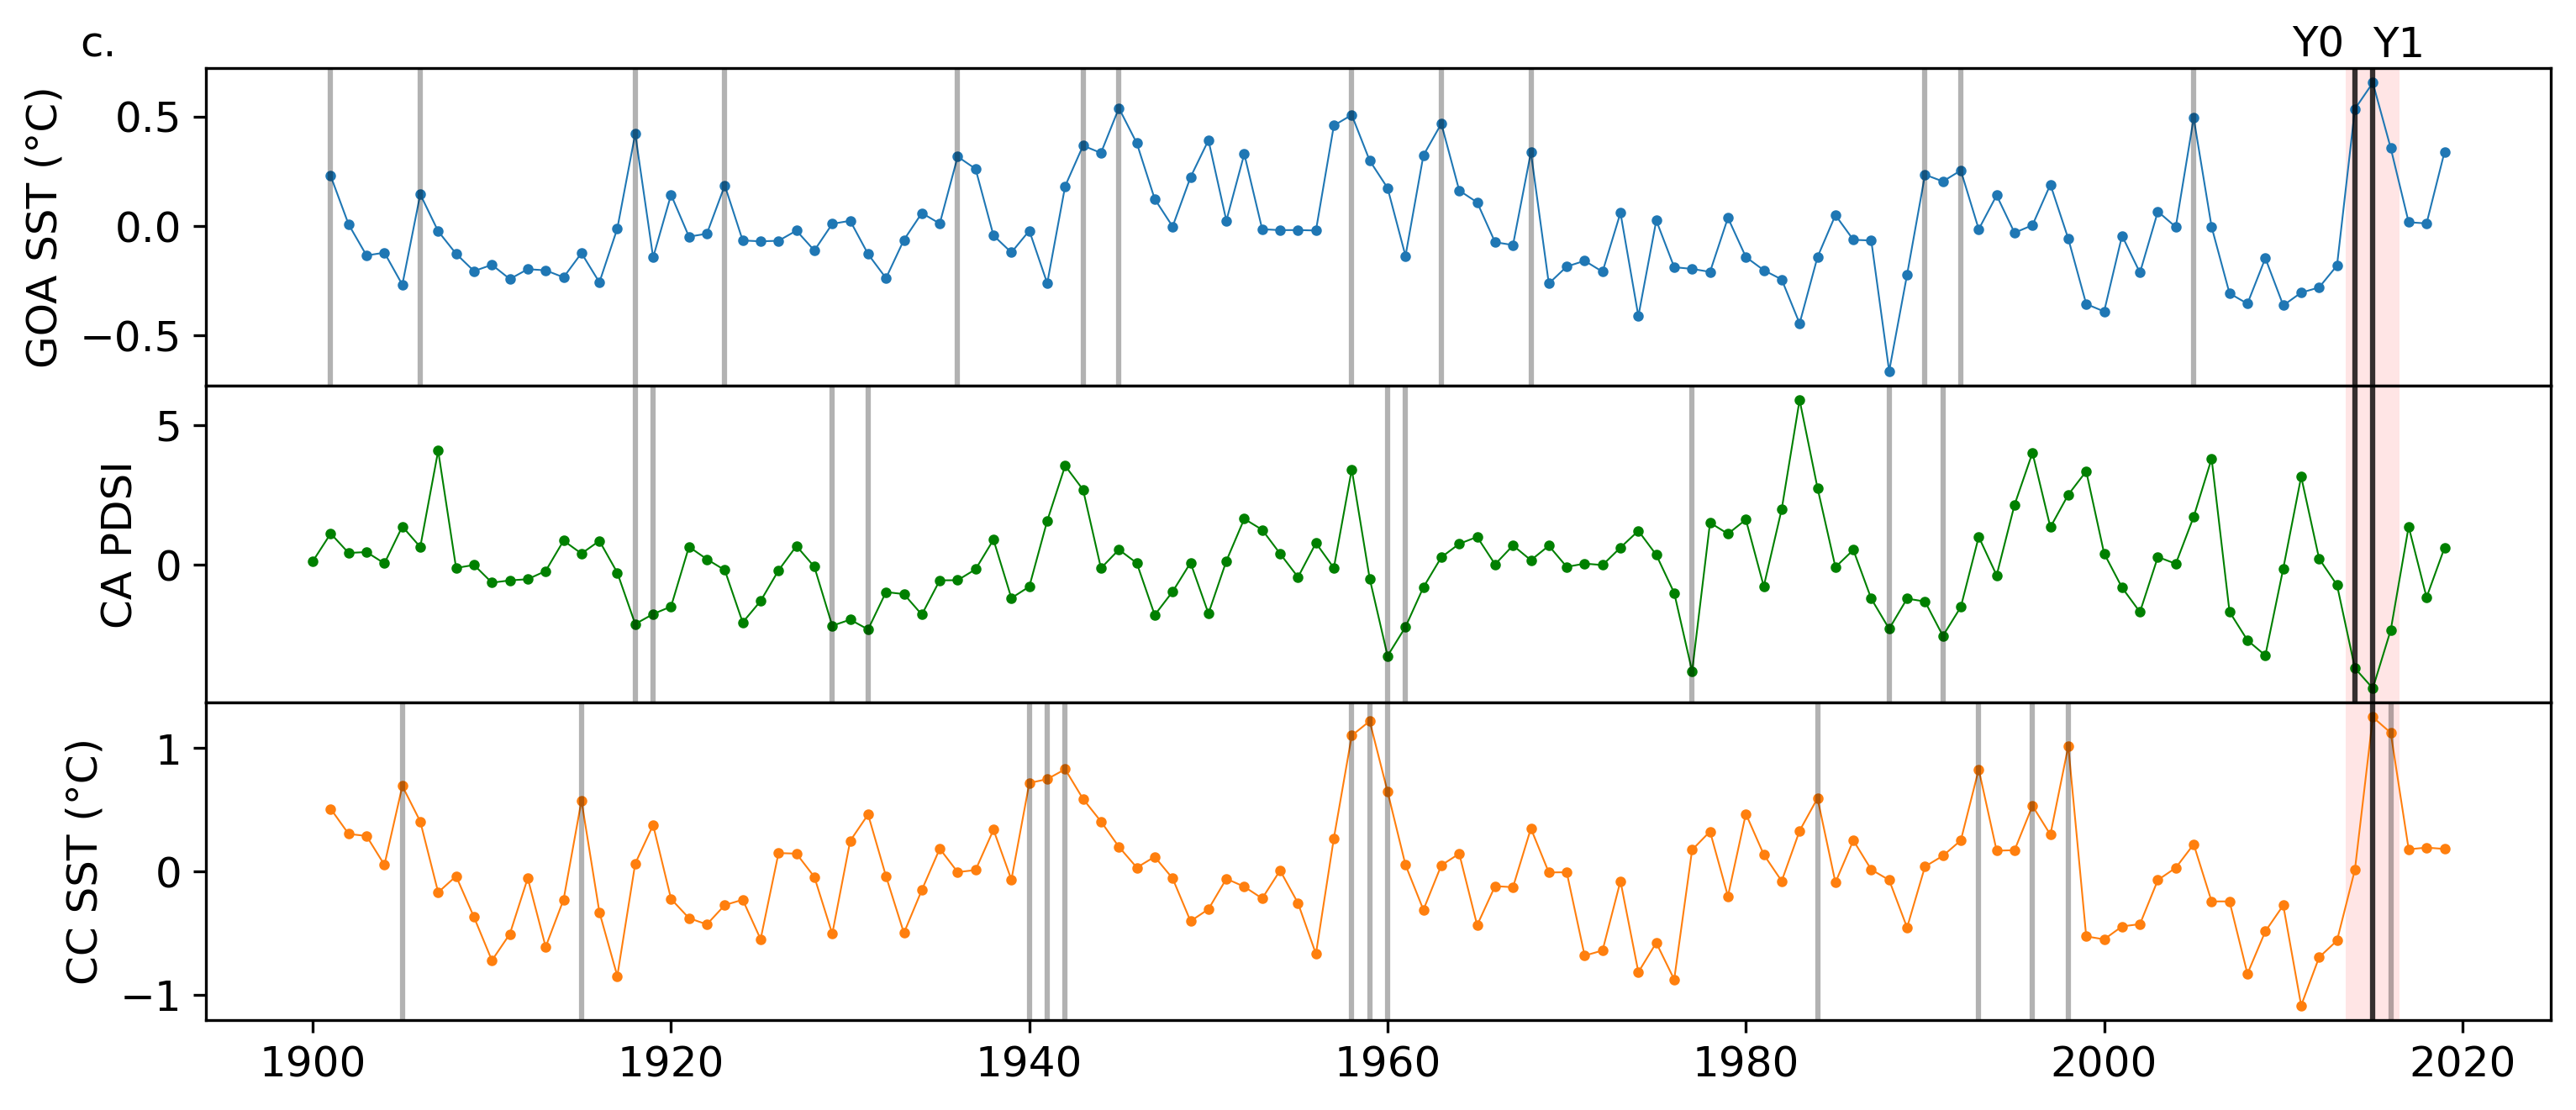

In [94]:
var1_0=df.CA_PDSI 
var2_0=df.CC_SST 
var3_0=df.GOA_SST 

#detrend
nsample = np.linspace(1,len(var1_0), len(var1_0))
[p_value, r2, var1]= detrend(nsample,var1_0,1)
nsample = np.linspace(1,len(var2_0), len(var2_0))
[p_value, r2, var2]= detrend(nsample,var2_0,1)
nsample = np.linspace(1,len(var3_0), len(var3_0))
[p_value, r2, var3]= detrend(nsample,var3_0,1)

from matplotlib import gridspec

#fig, ax3 = plt.subplots(figsize=(6,4),dpi=130)
#fig = plt.figure(dpi=130)
# set height ratios for sublots
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1,1]) 

fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, sharex=True, subplot_kw=dict(frameon=False),dpi=300,figsize=(12,5)) # frameon=False removes frames

fz=12

ax3 = plt.subplot(gs[0])
ax3.set_ylabel('GOA SST (°C)', fontsize=fz)#color='C0', 
ax3.plot(df.year,var3,'-o',color='C0',label='GOA SST',linewidth=.5, markersize=2)
ax3.tick_params(axis='y', labelsize=fz) #labelcolor='C0',
ax3.axvspan(2013.5, 2016.5, alpha=0.1, facecolor='r')
#ax3.axhline(linewidth=0.5,color='lightgreen')
#ax3.set_ylim([12, 14])
#ax3.set_xticks([]) 
#ax33 = ax3.twinx() 
#ax33.plot(df.year,var3_0,'-o',color='C0',label='GOA SST',linewidth=.5, markersize=2,alpha=.3)


ax1 = plt.subplot(gs[1], sharex = ax3)
ax1.set_ylabel('CA PDSI',  fontsize=fz)#color='g',
ax1.plot(df.year,var1,'-o',color='g',label='PDSI',linewidth=.5, markersize=2)
ax1.tick_params(axis='y', labelsize=fz) #labelcolor='g',
ax1.axvspan(2013.5, 2016.5, alpha=0.1, facecolor='r')
#ax1.xaxis.grid()  #grid(which='major', axis='x', linestyle='--') 
#ax1.set_ylim([-6, 6])
#ax1.set_xticks([]) 
#ax11 = ax1.twinx() 
#ax11.plot(df.year,var1_0,'-o',color='g',label='PDSI',linewidth=.5, markersize=2,alpha=.3)


ax2 = plt.subplot(gs[2], sharex = ax3) #ax1.twinx() 
ax2.set_ylabel('CC SST (°C)',  fontsize=fz) #color='C1',
ax2.plot(df.year,var2,'-o',color='C1',label='CC SST',linewidth=.5, markersize=2)
ax2.tick_params(axis='y', labelsize=fz)#labelcolor='C1',
ax2.tick_params(axis='x',labelsize=fz)
ax2.axvspan(2013.5, 2016.5, alpha=0.1, facecolor='r')

#ax2.set_ylim([15, 19])
#ax2.set_xticks([]) 
#ax22 = ax2.twinx() 
#ax22.plot(df.year,var2_0,'-o',color='C1',label='CC SST',linewidth=.5, markersize=2,alpha=.3)



for i in range(len(ca_dgt)):
    if ca_dgt.values[i]==1:
        #ax1.plot(1900+i,5,'x',color='k',markersize=2)
        ax1.axvline(x=1900+i,color='k',alpha=.3)
        
    if cc_mhw.values[i]==1:
        #ax2.plot(1900+i,16,'x',color='k',markersize=2)
        ax2.axvline(x=1900+i,color='k',alpha=.3)

    if goa_mhw.values[i]==1:
       #ax3.plot(1900+i,12,'x',color='k',markersize=2)
        ax3.axvline(x=1900+i,color='k',alpha=.3)

for i in range(110,116):
    if ca_dgt.values[i]==1:
        #ax1.plot(1900+i,5,'x',color='k',markersize=2)
        ax1.axvline(x=1900+i,color='k',alpha=.7)
        
    if cc_mhw.values[i]==1:
        #ax2.plot(1900+i,16,'x',color='k',markersize=2)
        ax2.axvline(x=1900+i,color='k',alpha=.7)

    if goa_mhw.values[i]==1:
       #ax3.plot(1900+i,12,'x',color='k',markersize=2)
        ax3.axvline(x=1900+i,color='k',alpha=.7)

plt.text(1887, 6.6, 'c.', fontsize=fz)
plt.text(2010.5, 6.6, 'Y0', fontsize=fz)
plt.text(2015, 6.6, 'Y1', fontsize=fz)
#plt.axvspan(2013.5, 2016.5, alpha=0.2, facecolor='r')



plt.subplots_adjust(hspace=.0)
plt.show()